# Regression Analysis - A Plan for This Lesson

We're going to learn a little bit about traditional statistical analyses.  The crucial piece here is not that you to fully understand all of traditional statistics -- that's another class -- but rather to gain a sense of what it can (and more importantly, what it *can not*) do.  

Traditional statistical analyses are how many people do exploratory research.  But do not make the classic research mistake of thinking that patterns that you find in your data represent reality. Regression analyses are powerful, but inept use of regressions also lays the groundwork for much of the replication crisis currently engulfing the social sciences.  If you haven't heard about [data dredging](https://en.wikipedia.org/wiki/Data_dredging), p-hacking and over-fitting, get used to those terms.  They are bane of modern research existence, and they are still really, really widespread.  More than that, even when using the best machine learning practices, people make all kinds of mistakes about what data should and should not be included in their particular application.  We'll talk a bit more about that as well. 

That plan for this lesson is to get some data sets loaded, make sure they're all properly geocoded and merged, and then look for patterns in the data.  We'll find one -- but it might not be as simple as it appears at first. 


# Startup - Installing and Importing

First things first: let's get all our packages installed and imported.  You'll see that we need to install geopandas and xtree. thankfully, statsmodels (the package we'll use to run our regressions) and seaboarn (the package we'll use to make some pretty plots) are both already installed, and we can just import them. 

In [1]:
#! conda install geopandas -yq

import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
% matplotlib  inline
import seaborn as sns; sns.set(color_codes=True)



Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    click-plugins:   1.0.3-py36_0      conda-forge
    cligj:           0.4.0-py36_0      conda-forge
    curl:            7.54.1-0          conda-forge
    descartes:       1.1.0-py36_0      conda-forge
    fiona:           1.7.9-py36_1      conda-forge
    freexl:          1.0.2-2           conda-forge
    gdal:            2.1.3-np112py36_3 conda-forge
    geopandas:       0.3.0-py36_0      conda-forge
    geos:            3.5.1-1           conda-forge
    giflib:          5.1.4-0           conda-forge
    hdf4:            4.2.12-0          conda-forge
    json-c:          0.12.1-0          conda-forge
    kealib:          1.4.7-1           conda-forge
    krb5:            1.14.2-0          conda-forge
    libdap4:         3.18.3-2          conda-forge
    libnetcdf:       4.4.1.1-4         conda-forge
    libpq:           9.6.3-0           conda-forge
    libspatialindex: 1.8.5

# 01 - reading in data

Let's read in some District crime data. Eventually we'll deal with crime & time in a more complex manner. 
For now, though, let's just have a look crime from a single year: 2010. Find the data on Open Data DC. Instead of downloading the data to your laptop, just copy the url for the "spreadsheet" under the download menu. Pandas is smart enough to just import it via the static url from that site. In a single line, read the data into a dataframe called "crimes" by using the pd.read_csv() function, and the url you just copied (inside quotation marks, because it's a string). 

In [3]:
crimes = pd.read_csv('https://opendata.arcgis.com/datasets/fdacfbdda7654e06a161352247d3a2f0_34.csv')

That was easy! One line and we have some great data from the web!  You'll see that we can't always do that, but it's nice when we can. 

# 02 - exploring the data

Ok, let's see what's in this data. 

In [4]:
print(crimes.columns)

Index(['X', 'Y', 'CCN', 'REPORT_DAT', 'SHIFT', 'METHOD', 'OFFENSE', 'BLOCK',
       'XBLOCK', 'YBLOCK', 'WARD', 'ANC', 'DISTRICT', 'PSA',
       'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'XCOORD', 'YCOORD', 'LATITUDE', 'LONGITUDE', 'BID',
       'START_DATE', 'END_DATE', 'OBJECTID'],
      dtype='object')


It looks like the types of offenses recorded here are probably labeled ... OFFENSE!  As we've seen before, 
one nice way to get a sense of the frequencies in our data is to use .value_counts().  Let's see how many crimes were committed in each ward. 

In [5]:
print(crimes.WARD.value_counts())

2.0    5548
8.0    4464
1.0    4358
6.0    4223
7.0    4008
5.0    3975
4.0    3091
3.0    1929
Name: WARD, dtype: int64


That's a mix of every kind of crime. Let's see if we can focus on violent crimes.  To figure out which of those we have in this data set, print out the value counts for the column named "OFFENSE". 

In [6]:
crimes.OFFENSE.value_counts()

THEFT/OTHER                   9282
THEFT F/AUTO                  8149
BURGLARY                      4057
MOTOR VEHICLE THEFT           3760
ROBBERY                       3681
ASSAULT W/DANGEROUS WEAPON    2340
SEX ABUSE                      156
HOMICIDE                       126
ARSON                           47
Name: OFFENSE, dtype: int64

It looks like the most violent offenses are, thankfully, also among the least common. But assoault with a dangerous weapon is still pretty common.  Let's focus on violent crimes against persons.  

# Subsetting
Although the final statement might seem complex, it's actually fairly straightforward once you get the hang of it.  


## 03 - True and false

First, let's create a set of logical statments that give us a "True" for each of the crimes we want.  

```crimes['OFFENSE']=='HOMICIDE'```

That is a piece of code that asks pandas "does the values in the column OFFENSE equal 'HOMICIDE', and it will return True or False for every single row in the dataframe. Try it out. 

In [7]:
crimes['OFFENSE']=='HOMICIDE';

Why is that helpful?  Because if we wanted to create a new dataframe with just homicides, we can now do the following: 

``` crimes[crimes['OFFENSE']=='HOMICIDE'] ```

Try it! 

In [8]:
crimes[crimes['OFFENSE']=='HOMICIDE']

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,XCOORD,YCOORD,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID
1,-76.988288,38.927727,4172632,2010-01-21T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,HAMLIN STREET NE AND 13TH STREET NE,401015.790015,139982.410015,...,9301.0,Precinct 73,NaN,NaN,38.927719,-76.988285,NaN,2004-12-19T00:45:00.000Z,2004-12-19T00:50:00.000Z,71503073
2,-76.957528,38.888178,6098962,2010-08-31T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,100 - 199 BLOCK OF 34TH STREET SE,403685.000000,135593.000000,...,7708.0,Precinct 132,403714.120,135573.330,38.888171,-76.957526,NaN,2006-07-23T01:40:00.000Z,2006-07-23T01:40:00.000Z,71503076
3,-77.072294,38.921513,7151899,2010-09-14T00:00:00.000Z,MIDNIGHT,OTHERS,HOMICIDE,2301 - 2499 BLOCK OF WISCONSIN AVENUE NW,393731.000000,139295.000000,...,300.0,Precinct 11,393805.570,139201.250,38.921505,-77.072292,NaN,2007-11-03T20:12:00.000Z,2007-11-03T20:15:00.000Z,71503083
5,-77.027039,38.921603,9160222,2010-04-06T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,2300 - 2499 BLOCK OF 11TH STREET NW,397655.460000,139302.910000,...,3600.0,Precinct 23,397646.320,139303.580,38.921595,-77.027036,NaN,2009-11-07T22:50:00.000Z,2010-04-06T00:00:00.000Z,71541869
149,-76.929050,38.908262,10008928,2010-01-20T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,1300 - 1399 BLOCK OF EASTERN AVENUE NE,406154.000000,137824.000000,...,7806.0,Precinct 93,406145.130,137797.080,38.908254,-76.929047,NaN,2010-01-20T14:45:00.000Z,2010-01-20T00:00:00.000Z,71545419
322,-77.021900,38.917011,10018111,2010-09-24T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,2000 - 2099 BLOCK OF GEORGIA AVENUE NW,398101.000000,138793.000000,...,3500.0,Precinct 37,398257.420,138853.510,38.917003,-77.021897,NaN,2010-02-12T06:28:00.000Z,2010-02-12T07:33:00.000Z,71545646
374,-76.998931,38.859936,10005583,2010-01-13T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,1100 - 1299 BLOCK OF EATON ROAD SE,400093.000000,132457.000000,...,7401.0,Precinct 119,400074.120,132444.830,38.859928,-76.998928,NaN,2010-01-13T12:56:00.000Z,2010-01-13T00:00:00.000Z,71545728
614,-76.999887,38.859359,10014232,2010-02-01T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,1100 - 1399 BLOCK OF STEVENS ROAD SE,400010.000000,132393.000000,...,7401.0,Precinct 119,400096.260,132252.000,38.859351,-76.999885,NaN,2010-02-01T00:26:00.000Z,2010-02-01T00:00:00.000Z,71546051
1330,-76.978323,38.843385,10000954,2010-01-03T00:00:00.000Z,MIDNIGHT,KNIFE,HOMICIDE,1700 - 1799 BLOCK OF MISSISSIPPI AVENUE SE,401882.000000,130620.000000,...,7409.0,Precinct 116,401871.690,130639.640,38.843377,-76.978321,NaN,2010-01-02T23:05:00.000Z,2010-01-02T00:00:00.000Z,71546770
1461,-76.989551,38.844500,10005224,2010-01-12T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,1200 - 1299 BLOCK OF ALABAMA AVENUE SE,400907.260000,130743.570000,...,10400.0,Precinct 119,400907.410,130739.450,38.844492,-76.989549,NaN,2010-01-12T15:47:00.000Z,2010-01-12T15:49:00.000Z,71546930


Do you see how we nested that line from above inside the square brackets after the crimes dataframe?  That tells pandas to return only those rows where the statement is true. And since it is only true where the OFFENSE is HOMICIDE, it is taking all the homicide rows from the crimes dataframe and copying them into the new homicide dataframe. 

But... we really want more than homicides.  So, we're going to combine three statments together: 

```
crimes['OFFENSE']=='HOMICIDE'
crimes['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON'
crimes['OFFENSE']=='SEX ABUSE'

```
And we'll link them with a funny symbol that means OR in python: |.  It's that straight line just above the downward slash over the enter/return key. 

In [9]:
crimes = crimes[(crimes['OFFENSE']=='HOMICIDE') | 
                (crimes['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON') |
                (crimes['OFFENSE']=='SEX ABUSE')]
print(crimes.OFFENSE.unique())

['HOMICIDE' 'ASSAULT W/DANGEROUS WEAPON' 'SEX ABUSE']


Now we have our violent crimes against persons in DC from 2010. Time to add some geography. 

# 04 - adding census data and geography

To read in our census data, I like to use geojson.  Geojson combines the shape data with other data in a single file. It tends to be large, but it's extremely convenient.  Let's try grabbing it from Opend data DC .  

In [10]:
tracts = gpd.read_file('https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson')

OSError: no such file or directory: 'opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson'

What?  I though pandas could read in data stright from from a URL?  Well: pandas can; geopandas can't.  We'll have to download this before loading into geopandas. But let's do this like the pros do.  To grab the data (the URL is available under the "APIs" dropdown menu as "geojson"), we'll use the fantastic unix command "wget".  We can take the crazy name in the URL and given a more reasonable name by using the -O option, thusly: 

In [11]:
! wget https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson -O census.geojson

--2017-09-24 20:30:52--  https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 34.206.73.45, 52.23.40.223
Connecting to opendata.arcgis.com (opendata.arcgis.com)|34.206.73.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘census.geojson’

census.geojson          [ <=>                ]   1.71M  --.-KB/s    in 0.02s   

2017-09-24 20:30:52 (85.9 MB/s) - ‘census.geojson’ saved [1794478]



# 05 - reading the data into geopandas

OK, recall that reading in to geopandas is as easy as ```gpd.read_file()```. Load that file named "census.geojson" into a geopandas dataframe called "census".  It's already in your working direcory in the cloud thanks to wget.  :-)

In [14]:
census = gpd.read_file("census.geojson")

Nice.  Now let's see what the data looks like. 

In [15]:
census.columns

Index(['OBJECTID', 'TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003',
       'P0010004', 'P0010005', 'P0010006', 'P0010007', 'P0010008', 'OP000001',
       'OP000002', 'OP000003', 'OP000004', 'P0020002', 'P0020005', 'P0020006',
       'P0020007', 'P0020008', 'P0020009', 'P0020010', 'OP00005', 'OP00006',
       'OP00007', 'OP00008', 'P0030001', 'P0030003', 'P0030004', 'P0030005',
       'P0030006', 'P0030007', 'P0030008', 'OP00009', 'OP00010', 'OP00011',
       'OP00012', 'P0040002', 'P0040005', 'P0040006', 'P0040007', 'P0040008',
       'P0040009', 'P0040010', 'OP000013', 'OP000014', 'OP000015', 'OP000016',
       'H0010001', 'H0010002', 'H0010003', 'ACRES', 'SQ_MILES', 'Shape_Length',
       'Shape_Area', 'FAGI_TOTAL_2010', 'FAGI_MEDIAN_2010', 'FAGI_TOTAL_2013',
       'FAGI_MEDIAN_2013', 'geometry'],
      dtype='object')

Blargh.  Why did the census name everything with code?  I guess because computers used to have tiny, tiny eight character naming limits. Well, I'll tell you what.  FAGI is the "Federal Adjusted Gross Income", and it's a very valuable little piece of data to have. There are also data on race, ethnicity and -- if we do a little math -- population density in here.  

But before we get into all that, let's take the data for violent crimes in 2010 and plot it inside our census tracts like we learned last week. 

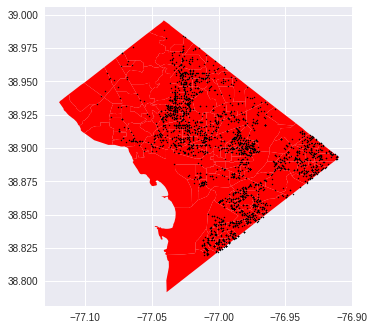

In [16]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(crimes.LONGITUDE.apply(float), crimes.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(crimes, crs=crs, geometry=geometry)
fig, ax = plt.subplots()
census.plot(ax=ax, color='red')
points.plot(ax=ax, color='black', marker='.', markersize=5)
ax.set_aspect('equal')  # remember, this is what we need to do in order to not have a crazy wide map. 

We still need to aggregate the crime into each census tract, and to do that we need to join that crime data with the census tract data. 

In [19]:
geo_crimes = gpd.sjoin(census, points, how='left', op='intersects')
geo_crimes.head()

,OBJECTID_left,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,CENSUS_TRACT,VOTING_PRECINCT,XCOORD,YCOORD,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID_right
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,1001.0,Precinct 31,392731.23,143165.70,38.956486,-77.083553,NaN,2010-06-29T01:45:00.000Z,NaN,71717603.0
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,1001.0,Precinct 30,392559.52,141723.10,38.943161,-77.085003,NaN,2010-11-20T22:30:00.000Z,2010-11-20T23:59:00.000Z,71725368.0
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,1001.0,Precinct 31,392840.26,142659.85,38.952099,-77.082452,NaN,2010-09-16T09:10:00.000Z,2010-09-16T09:30:00.000Z,71720149.0
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,1001.0,Precinct 31,392914.36,142701.64,38.952703,-77.081622,NaN,2010-06-13T02:45:00.000Z,2010-06-13T03:00:00.000Z,71553666.0
1,2,001002,11001001002,3442,3329,2788,185,7,311,0,...,600.0,Precinct 29,NaN,NaN,38.937287,-77.073793,NaN,2010-11-04T00:55:00.000Z,2010-11-04T00:57:00.000Z,71812696.0


Now we have the data in pretty much the format we want.  We have a bunch of census tracts wtih crimes aggregated.  But what we still don't know is how many crimes are committed *per capita*, which is far more informative than just how many crimes have occured. For that we need to know the total population in each census tract.  And that is actually in the column named "P0010001". What a great name.  The best.  All right, putting it all together, just like we did last week, we get: 

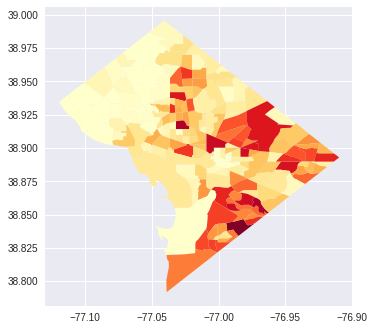

In [20]:
crimes_percap = pd.DataFrame(geo_crimes.OBJECTID_left.value_counts()*100000/geo_crimes.P0010001.sum())
crimes_percap.columns = ['crimes_percap']
tracts_crimes = census.merge(crimes_percap, how="left", left_on='OBJECTID', right_index=True)
tracts_crimes.plot(column='crimes_percap', cmap='YlOrRd')

# 06 - drawing some dots and some lines

As this lesson is about the traditional statistical technique of regression, we're going to do what researchers did for ages before they had machine learning algorithms: look at some simple patterns.  If X and Y are positively correlated, that means that the higher X is, at least on average, the higher Y is.  And if X and Y are negatively correlated, when X goes higher, Y goes lower. 

Let's draw a fairly simple plot, then we can try to see if there is a pattern we can discern.  Try this: 



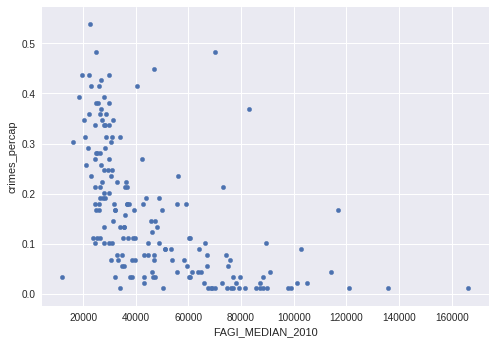

In [21]:
df = pd.DataFrame(tracts_crimes[['FAGI_MEDIAN_2010', 'crimes_percap']])
df.plot.scatter('FAGI_MEDIAN_2010', 'crimes_percap')

That seems like a pretty steep falloff as income goes up.   

If you drew a line through those dots, what would it look like?  We'll try a few statistical technicques, but you could probably just draw a line with you finger on the screen. Do it slant upward or downward as you move from left to right?  

Better than imagining a line, we could actually draw using math.  Or, better still, let the comupter draw one using math!  To do this, we'll use the delightful package called "seaborn" that we loaded at the top of the page. 

Seaborn is going to fit a line using simple linear regression, a line that has the least "residual error" possible.  This means that if you moved the line in any way, the overall sum of the distances between the dots and the line with INCREASE.  

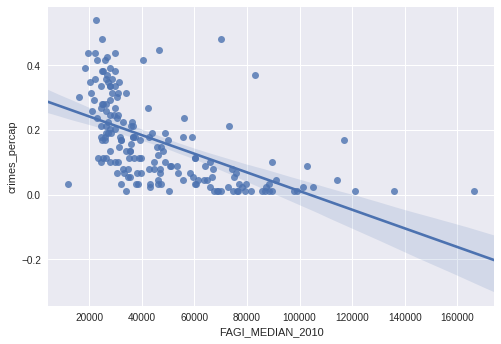

In [22]:
ax = sns.regplot(x="FAGI_MEDIAN_2010", y="crimes_percap", data=tracts_crimes)

That line is as close to ALL the dots as a straight line can be.  This is known as linear regression. And we can actually figure out a lot fo things about how good a fit it is if we use the statsmodels package.  

Let's fit a model that has just those two variables: income and crime rate. 

In [23]:
model = 'crimes_percap ~ FAGI_MEDIAN_2010'

results = smf.ols(model, data=tracts_crimes).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          crimes_percap   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     83.67
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           1.38e-16
Time:                        20:38:58   Log-Likelihood:                 144.41
No. Observations:                 179   AIC:                            -284.8
Df Residuals:                     177   BIC:                            -278.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2996      0.017  

So from this output we can learn a lot.  First, the R-squared tells us about what percentage of the variation in the crime rate is also associated with variation in median income.  So there's roughly at 32% association.  That's better than nothing, but pretty far short of 100%.  And, if you are like puzzles, you'll be tempted to see if you can "explain" more of the variation.  That's good -- but also potentially bad. 

Let's see what we can do with a few reasonable adjustments. First, if you were drawing a line through those dots, and you could bend it a bit, would it be a better fit?  Probably, right?  the dots all seem to cluster near the axes.  In fact, if we want to, we can check this intuition by drawing what is called a "local fit" regression line. This is often referred to as "loess" or "lowess".  And seaborn has a very nice one.  

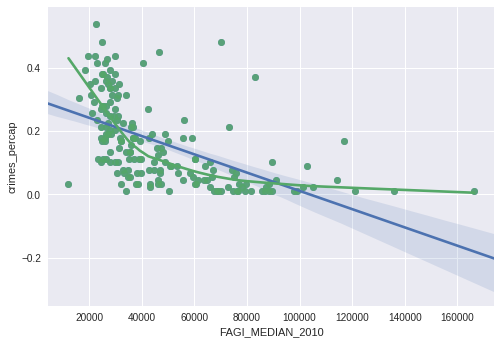

In [24]:
ax = sns.regplot(x="FAGI_MEDIAN_2010", y="crimes_percap", data=tracts_crimes)
sns.regplot(x="FAGI_MEDIAN_2010", y="crimes_percap", data=tracts_crimes, lowess=True)

When a statistician sees a plot like this, they think: LOG scale.  A log scale just means reducing a number by a factor. So: 

```
number  log
0.001   -3
0.01    -2
0.1     -1
1        0
10       1
100      2
1000     3
```

The highly technical term for this that I like to use is "unsmooshing".  Let's try that here by applying a log transformation to each of the variables. 

In [26]:
tracts_crimes['income_log'] = tracts_crimes['FAGI_MEDIAN_2010'].apply(np.log)
tracts_crimes['crime_log'] = tracts_crimes['crimes_percap'].apply(np.log)

Now take the same from above (the two lines for the seaborn plots) and subsitute the variables we just recreated.  

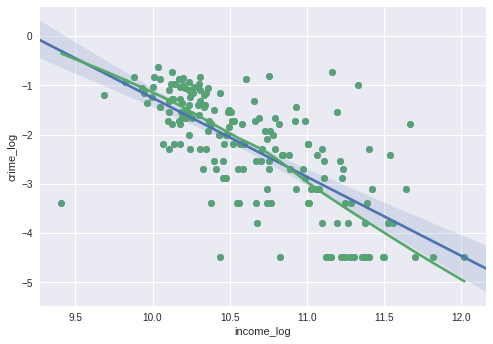

In [27]:
ax = sns.regplot(x='income_log', y='crime_log', data=tracts_crimes)
sns.regplot(x='income_log', y='crime_log', data=tracts_crimes, lowess=True)

Notice that there is actually very little difference between straight line in the linear regression (blue), and the "local fit" line in the the lowess regression (green). So it looks like we were correct -- this is a log distribution in both directions.  You'll find that income data are almost always like this: people tend to cluster at the bottom of the scale, and at the top people are really, really rich. This pattern is true of many other measures as well. 

In human terms, what this means is that the dropoff in the crime rate associated with increased median income in a census tract are both very steep, but grows less steep over time. Increasingly larger amounts of income (log of the income) are correlated with a increasingly smaller reductions in the violent crime rate (log of crime percapita).  Another way of putting it is that the loss of each subsequent dollar of income is associated with a substantially larger increase in violent crime.  Many data sets contain log distributions -- that is, they are both concentrated at the low end of the scale. 

And, indeed, this does make for a better statistical fit when we have a look at the regression statistics in statsmodels: 

In [28]:
model = 'np.log(crimes_percap) ~ np.log(FAGI_MEDIAN_2010) '

results = smf.ols(model, data=tracts_crimes).fit()

print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(crimes_percap)   R-squared:                       0.492
Model:                               OLS   Adj. R-squared:                  0.489
Method:                    Least Squares   F-statistic:                     171.4
Date:                   Sun, 24 Sep 2017   Prob (F-statistic):           7.99e-28
Time:                           20:41:51   Log-Likelihood:                -212.99
No. Observations:                    179   AIC:                             430.0
Df Residuals:                        177   BIC:                             436.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Indeed, median income appears to explain away nearly 50% of the variation in violent crime.  Or is it the other way around?  Does poverty lead to violence, or does violence drive away money?  It's not an idle question, and a great deal of thought needs to go into the answer before we even begin to think about using this model to inform a particular public policy or practice. 

There are other ways of increasing fit, and we could have chosen from many different types of transformations or models of the data.  

# Danger, Will Robinson, Danger!

But for the reckless, why stop at one variable?  The world is full of data, and researchers have thrown a lot of data crime to see what is correlated and what drives up their R-squared. I'll create a few more variables to add to the mix, and you can play around with the formulas in the equation.  

In [29]:
tracts_crimes['percent_white'] = tracts_crimes['P0010003'] / tracts_crimes['P0010001']
tracts_crimes['percent_black'] = tracts_crimes['P0010004'] / tracts_crimes['P0010001']
tracts_crimes['percent_asian'] = tracts_crimes['P0010006'] / tracts_crimes['P0010001']
tracts_crimes['population_density'] = tracts_crimes['P0010001'] / tracts_crimes['SQ_MILES']

In [30]:
model = 'crime_log ~ income_log + population_density + percent_white + percent_black + percent_asian '
results = smf.ols(model, data=tracts_crimes).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              crime_log   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     46.06
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           4.33e-30
Time:                        20:44:25   Log-Likelihood:                -197.84
No. Observations:                 179   AIC:                             407.7
Df Residuals:                     173   BIC:                             426.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.1475      2

# crazy interactions

Just to show you how crazy these models can get, I'll fully interact all the variables, meaning that I'm assuming all the variables interact with each other in a way that matters to crime.  I have not real theory -- indeed I doubt one could come up with a reasonable one -- but you should know that p-hackers tend to interact almost everthing, then drop the less promsing interactions.  The theory the data supports is then invented after they have found novel pattern in the data. Publication gold! But terrible for science and even worse for public policy. 

To commit this statistical crime, run the same commands, but inside the formual, replace the plus sign with an asterisk (\* instead of +)

In [33]:
model = 'crime_log ~ income_log + population_density + percent_white + percent_black + percent_asian '
model = model.replace("+", "*")
print(model)
results = smf.ols(model, data=tracts_crimes).fit()
print(results.summary())

crime_log ~ income_log * population_density * percent_white * percent_black * percent_asian 
                            OLS Regression Results                            
Dep. Variable:              crime_log   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     9.998
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           3.58e-23
Time:                        20:45:42   Log-Likelihood:                -172.09
No. Observations:                 179   AIC:                             408.2
Df Residuals:                     147   BIC:                             510.2
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|  

# errr...

But, hey, our R-squared keeps going up ... we must be doing something right!  



# automating the data dredge

Sometimes -- not when trying to make any claims about causation -- but sometimes when doing exploratory analyses, you might just want to automate your data dredging workflow.  Many statistical packages actually have something called "stepwise regression" that does this for the researcher.  Stepwise regression is meant to be exploratory, but because almost no one who publishes results pre-registers their experiments it has become a mainstay of the academic publishing dystopia.  People get data, run a bazillion transformations and interactions, then run stepwise regression to maximize their R-squared, increase their confidence intervals, and come out with a totally confabulated hypothesis that their analysis "tests".  

In future weeks, we'll start to see how this kind of automation, when done correctly, can be a good thing.  But for now, let's just see how we would do this in Python, which does not have a package to do this.  We'll just make a simple function that can iterate through a fully interacted model.  

You don't have to understand all the code to know this: many researchers do things like this all the time, building up extremely fragile models that increase the fit fo the their model, but have no theory and are never really thought through.  Needless to say, you shouldn't do it.  But with that advice, let's do something really stupid, so we can learn a bit about how sci-kit learn work later on. 

In [34]:

def data_mining(data, dv):
    remaining = set(data.columns)
    remaining.remove(dv)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(dv, ' * '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(dv, ' * '.join(selected))
    model = smf.ols(formula, data).fit()
    return model



In [40]:
myvars = ['crime_log', 'income_log', 'population_density', 'FAGI_TOTAL_2010']

df = pd.DataFrame(tracts_crimes[myvars])
mining = data_mining(df,'crime_log')
mining.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crime_log   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     57.80
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           5.13e-26
Time:                        20:49:41   Log-Likelihood:                -211.97
No. Observations:                 179   AIC:                             431.9
Df Residuals:                     175   BIC:                             444.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     14.2870      1.877      7.613      0.000      10.583      17.991
income_log                    -1.5676      0.179     -8.749      0.000      -1.921      -1.214
FAGI_TOTAL_2010             2.175e-08   1.55e-08      1.407      0.161   -8.75e-09    5.23e-08
income_log:FAGI_TOTAL_2010  -1.88e-09   1.34e-09     -1.398      0.164   -4.53e-09    7.74e-10
==============================================================================
Omnibus:                       10.463   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.720
Skew:                          -0.303   Prob(JB):                     0.000234
Kurtosis:                       4.369   Cond. No.                     5.83e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# adding more variables
Ok, now add the following to our list of variables to myvars: 
```
'percent_asian', 'percent_white', 'percent_black'
```

In [41]:
myvars += ['percent_asian', 'percent_white', 'percent_black']
df = pd.DataFrame(tracts_crimes[myvars])
mining = data_mining(df,'crime_log')
mining.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crime_log   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     10.08
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           7.06e-26
Time:                        20:49:51   Log-Likelihood:                -136.66
No. Observations:                 179   AIC:                             369.3
Df Residuals:                     131   BIC:                             522.3
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  -0.1048      0.120     -0.874      0.384      -0.342       0.133
income_log                                                                                 -0.5211      0.437     -1.192      0.236      -1.386       0.344
percent_asian                                                                               0.0039      0.008      0.469      0.640      -0.013       0.020
income_log:percent_asian                                                                    0.0973      0.162      0.600      0.549      -0.223       0.418
percent_white                                                                              -0.0457      0.038     -1.217      0.226      -0.120       0.029
income_log:percent_white                                                                    0.1893      0.496      0.381      0.704      -0.793       1.171
percent_asian:percent_white                                                                -0.0001      0.003     -0.042      0.967      -0.006       0.006
income_log:percent_asian:percent_white                                                      0.0231      0.060      0.386      0.700      -0.095       0.141
FAGI_TOTAL_2010                                                                          1.669e-06    1.2e-06      1.386      0.168   -7.13e-07    4.05e-06
income_log:FAGI_TOTAL_2010                                                              -1.605e-07   1.09e-07     -1.468      0.144   -3.77e-07    5.58e-08
percent_asian:FAGI_TOTAL_2010                                                           -1.233e-05   2.52e-05     -0.488      0.626   -6.23e-05    3.76e-05
income_log:percent_asian:FAGI_TOTAL_2010                                                 1.164e-06   2.23e-06      0.521      0.603   -3.25e-06    5.58e-06
percent_white:FAGI_TOTAL_2010                                                           -1.695e-06   1.28e-06     -1.326      0.187   -4.22e-06    8.33e-07
income_log:percent_white:FAGI_TOTAL_2010                                                  1.64e-07   1.15e-07      1.422      0.157   -6.42e-08    3.92e-07
percent_asian:percent_white:FAGI_TOTAL_2010                                              9.021e-06    2.8e-05      0.322      0.748   -4.64e-05    6.44e-05
income_log:percent_asian:percent_white:FAGI_TOTAL_2010                                  -8.741e-07   2.47e-06     -0.354      0.724   -5.75e-06    4.01e-06
population_density                                                                          0.0064      0.009      0.74

Hey, the R-squared went up again!  We must be geniuses.  

OK, enough of the bad stats practices. We'll soon see how to turn these to the power of good.  But please just remember: with great power...